## 1. 프로젝트 개요

- **주제: 배달 산업 분석과 마케팅 방향성 모색**
- 설명: 2021년 배달 주문 건수 데이터를 통해 업황을 확인하고, 배달업계의 마케팅 추진 방향성을 모색
- 데이터셋
    - [업종 목적지별 배달 주문건수](https://bdp.kt.co.kr/invoke/SOKBP2603/?goodsCode=KGUDSTNORDER)(통신 빅데이터 플랫폼)
- 진행 절차 및 내용
    - 데이터 로딩, 결측치 처리 및 파생 변수 생성, 컬럼별 분포 확인 및 **시각화** 진행
    - 시간대 단위로 **K-Means Clustering** 수행하여 주문량 많은 군집 선정
    - 주문량 많은 군집에서 가장 주문량이 많은 메뉴를 확인하기 위해 **등분산 검정과 t-test** 수행
    - 분석 결과로부터, 매일 오후 6시에 할인 쿠폰을 발급하는 게릴라성 앱 푸시 이벤트 기획
- 사용한 스킬셋
    - pandas
    - matplotlib, seaborn
    - scikit-learn
    - scipy

## 2. 데이터 로딩 및 분포 확인

### 2-1. 데이터 불러오기

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
from sklearn.cluster import KMeans
from scipy import stats

In [2]:
names = ['DE', 'HRLY_TIME', 'DLVR_STORE_INDUTY_NM', 'DLVR_DSTN_BRTC_NM', 'DLVR_DSTN_SIGNGU_NM', 'OREDER_CASCNT']
delivery_df = pd.read_csv('KGU_3rd_ORIGIN_KGUDSTNORDER_20210101000000.csv', names=names)
delivery_df

,DE,HRLY_TIME,DLVR_STORE_INDUTY_NM,DLVR_DSTN_BRTC_NM,DLVR_DSTN_SIGNGU_NM,OREDER_CASCNT
0,2021-01-01,0,돈까스/일식,경기도,동두천시,3
1,2021-01-01,0,돈까스/일식,경기도,부천시,49
2,2021-01-01,0,돈까스/일식,경기도,안산시 상록구,5
3,2021-01-01,0,돈까스/일식,경기도,의정부시,6
4,2021-01-01,0,돈까스/일식,경상남도,진주시,3
...,...,...,...,...,...,...
1026041,2021-07-31,23,한식,제주특별자치도,서귀포시,1
1026042,2021-07-31,23,한식,충청남도,천안시 서북구,2
1026043,2021-07-31,23,회,경기도,이천시,2
1026044,2021-07-31,23,회,전라남도,광양시,2


In [13]:
delivery_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026046 entries, 0 to 1026045
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   DE                    1026046 non-null  object
 1   HRLY_TIME             1026046 non-null  int64 
 2   DLVR_STORE_INDUTY_NM  1026046 non-null  object
 3   DLVR_DSTN_BRTC_NM     1026046 non-null  object
 4   DLVR_DSTN_SIGNGU_NM   1026046 non-null  object
 5   OREDER_CASCNT         1026046 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 47.0+ MB


In [14]:
delivery_df.isna().sum()

DE                      0
HRLY_TIME               0
DLVR_STORE_INDUTY_NM    0
DLVR_DSTN_BRTC_NM       0
DLVR_DSTN_SIGNGU_NM     0
OREDER_CASCNT           0
dtype: int64

살펴본 결과
- 컬럼 이름을 한글로 바꾸면 직관적이긴 하겠다만 컬럼 수가 많지도 않고 대충 뭔지 알겠으니 굳이 필요는 없을 듯
- 결측치 없어서 깨끗하다
- ```DE```(날짜)랑 ```HRLY_TIME```(시간대)이 비슷한 결이고 ```DLVR_DSTN_BRTC_NM```(도)랑 ```DLVR_DSTN_SIGNGU_NM```(시군구)이 비슷한 결이다

### 2-2. 컬럼별 분포 확인 (날짜 및 시간)

In [25]:
delivery_df['DE'].nunique()

205

205일...? 1년치 데이터라더니 뭔가 많이 부족하다.

In [3]:
delivery_df['Month'] = delivery_df['DE'].str[5:7]
delivery_df['Month'].unique()

array(['01', '02', '03', '04', '05', '06', '07'], dtype=object)

1월부터 7월까지 있는 모양이다.

In [29]:
months = {
    '01': 31,
    '02': 28,
    '03': 31,
    '04': 30,
    '05': 31,
    '06': 30,
    '07': 31
}

print(sum(months.values()))

212


하지만 여전히 7일이 누락되어 있다.

In [31]:
dates = []
unique_dates = list(delivery_df['DE'].unique())

for month, days in months.items():
    for day in range(1, days + 1):
        day_str = str(day) if day >= 10 else f'0{str(day)}'
        dates.append(f'2021-{month}-{day_str}')
        
for date in dates:
    if date in unique_dates:
        continue
    else:
        print(date)

2021-03-27
2021-03-28
2021-03-29
2021-03-30
2021-03-31
2021-07-20
2021-07-21


3월과 7월의 일부분이 누락되었음을 확인할 수 있다.

In [4]:
count_by_time = delivery_df.groupby('HRLY_TIME').agg({'OREDER_CASCNT': 'sum'})
count_by_time

,OREDER_CASCNT
HRLY_TIME,
0,82459
1,39123
2,16043
3,7271
4,4779
5,3258
6,3347
7,4010
8,10260


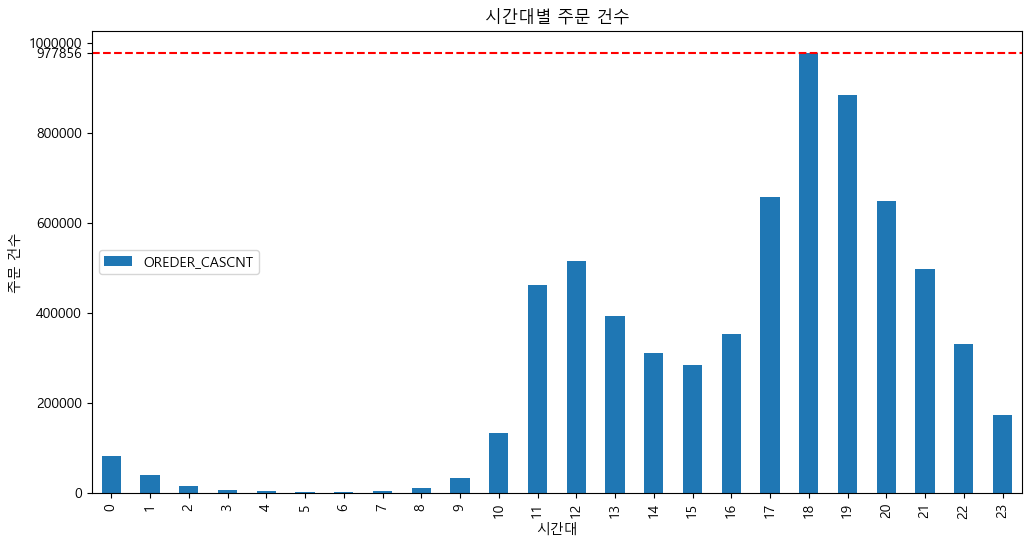

In [277]:
count_by_time.plot(kind='bar', figsize=(12, 6))
plt.title('시간대별 주문량')
plt.xlabel('시간대')
plt.ylabel('주문량')
plt.yticks([i for i in range(0, 1000001, 200000)] + [count_by_time.max().item()])
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
plt.axhline(count_by_time.max().item(), color='red', linestyle='--')
plt.show()

시간대는 0시부터 23시까지 누락 없이 들어가 있고, 시간대별 주문량을 보면 확실히 **저녁 시간대**가 압도적으로 많다.

### 2-3. 컬럼별 분포 확인 (메뉴)

In [63]:
delivery_df['DLVR_STORE_INDUTY_NM'].unique()

array(['돈까스/일식', '배달전문업체', '분식', '아시안/양식', '야식', '족발/보쌈', '중식', '찜탕',
       '치킨', '카페/디저트', '패스트푸드', '피자', '한식', '회', '심부름', '도시락'],
      dtype=object)

In [281]:
count_by_menu = delivery_df.groupby('DLVR_STORE_INDUTY_NM').agg({
    'OREDER_CASCNT': 'sum'
}).sort_values('OREDER_CASCNT', ascending=False)
count_by_menu

,OREDER_CASCNT
DLVR_STORE_INDUTY_NM,
돈까스/일식,1321584
치킨,1047851
한식,815165
카페/디저트,745818
분식,601403
패스트푸드,424633
중식,316226
족발/보쌈,301537
찜탕,298491


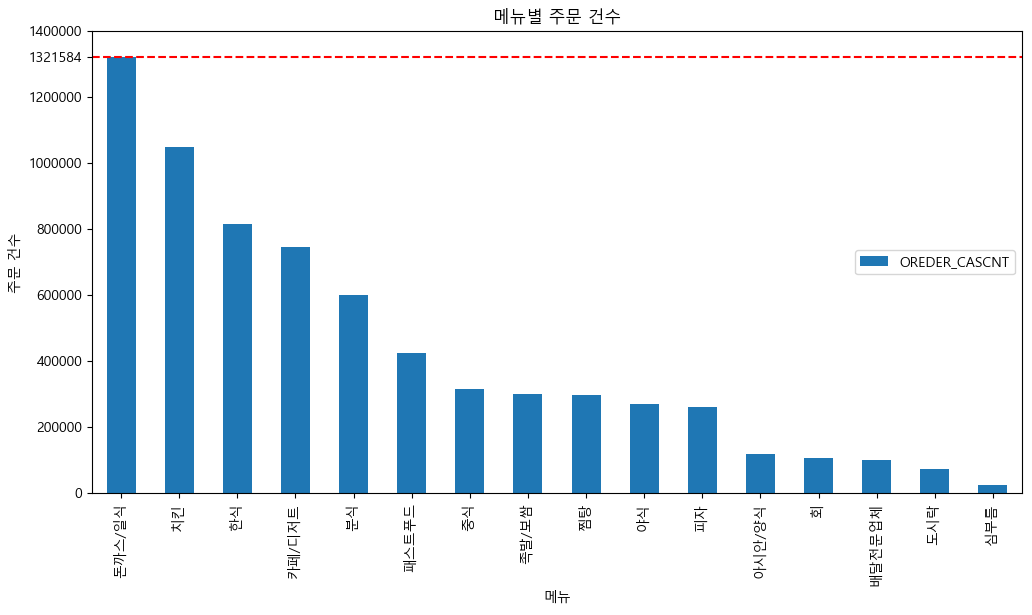

In [286]:
count_by_menu.plot(kind='bar', figsize=(12, 6))
plt.title('메뉴별 주문량')
plt.xlabel('메뉴')
plt.ylabel('주문량')
plt.yticks([i for i in range(0, 1400001, 200000)] + [count_by_menu.max().item()])
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
plt.axhline(count_by_menu.max().item(), color='red', linestyle='--')
plt.show()

역시 생각했던 대로 **돈까스/일식**과 **치킨**의 비율이 압도적이다. 그나저나 야식이 따로 분리되어 있는 이유는 뭘까... 야식 하면 치킨, 족발, 보쌈 아닌가 싶은데 이 친구들이 이미 다 존재하는데?

### 2-4. 컬럼별 분포 확인 (행정구역)

In [287]:
count_by_do = delivery_df.groupby('DLVR_DSTN_BRTC_NM').agg({
    'OREDER_CASCNT': 'sum'
}).sort_values('OREDER_CASCNT', ascending=False)
count_by_do

,OREDER_CASCNT
DLVR_DSTN_BRTC_NM,
경기도,3633707
서울특별시,775786
충청남도,555855
경상북도,398771
경상남도,292061
부산광역시,244746
전라남도,226342
인천광역시,190252
충청북도,139037


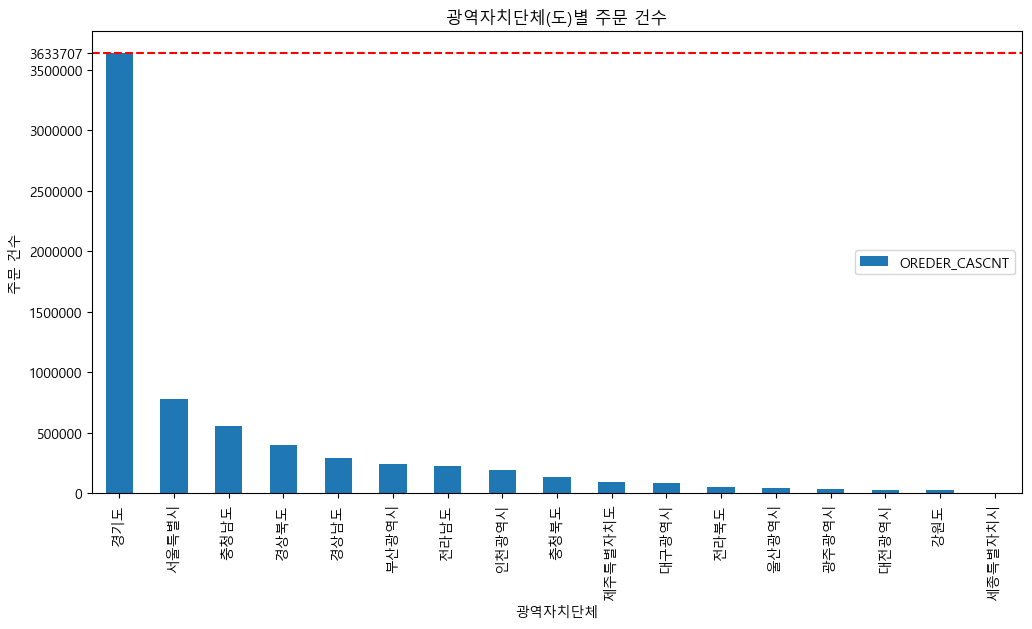

In [295]:
count_by_do.plot(kind='bar', figsize=(12, 6))
plt.title('광역자치단체(도)별 주문량')
plt.xlabel('광역자치단체')
plt.ylabel('주문량')
plt.yticks([i for i in range(0, 3500001, 500000)] + [count_by_do.max().item()])
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
plt.axhline(count_by_do.max().item(), color='red', linestyle='--')
plt.legend(loc='center right')
plt.show()

경기도가 상상 이상으로 압도적으로 많구나...?

In [329]:
do_iter = iter(delivery_df.groupby('DLVR_DSTN_BRTC_NM'))

def draw_si_plot(do, df, yticks=[]):
    '''
    각 도별로 시군구별 행 개수를 집계한 후 시각화하는 함수
    '''
    count_by_si = df.groupby('DLVR_DSTN_SIGNGU_NM').agg({
        'OREDER_CASCNT': 'sum'
    }).sort_values('OREDER_CASCNT', ascending=False)
    
    count_by_si.plot(kind='bar', figsize=(12, 6))
    plt.title(f'{do} 자치단체(시군구)별 주문량')
    plt.xlabel('자치단체')
    plt.ylabel('주문량')
    if yticks:
        plt.yticks(yticks + [count_by_si.max().item()])
    plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
    plt.axhline(count_by_si.max().item(), color='red', linestyle='--')
    plt.legend(loc='center right')
    plt.show()

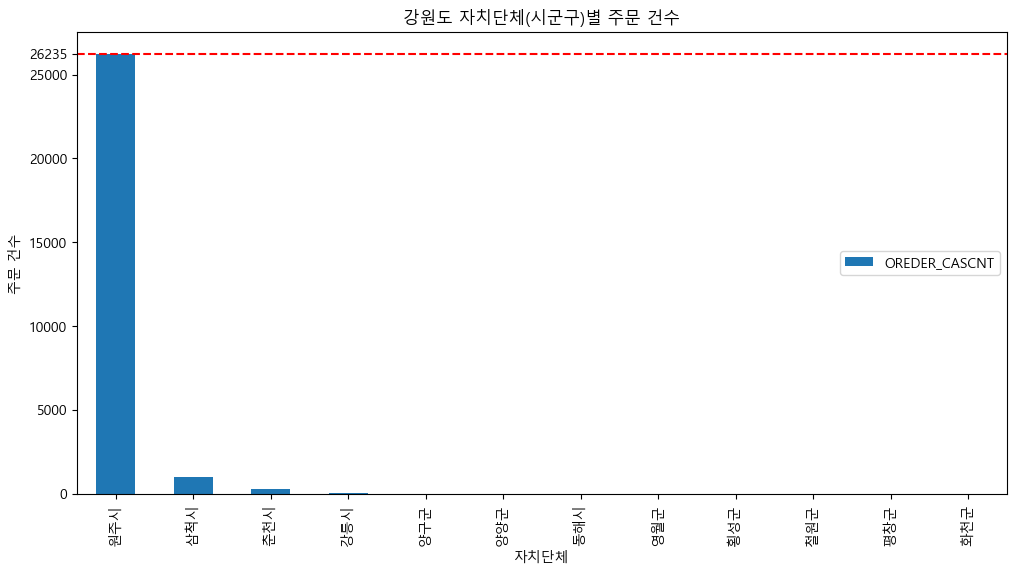

In [330]:
do, si_df = next(do_iter)
draw_si_plot(do, si_df, [i for i in range(0, 25001, 5000)])

강원도는 춘천, 강릉보다 삼척이 더 많은 게 굉장히 의외다.

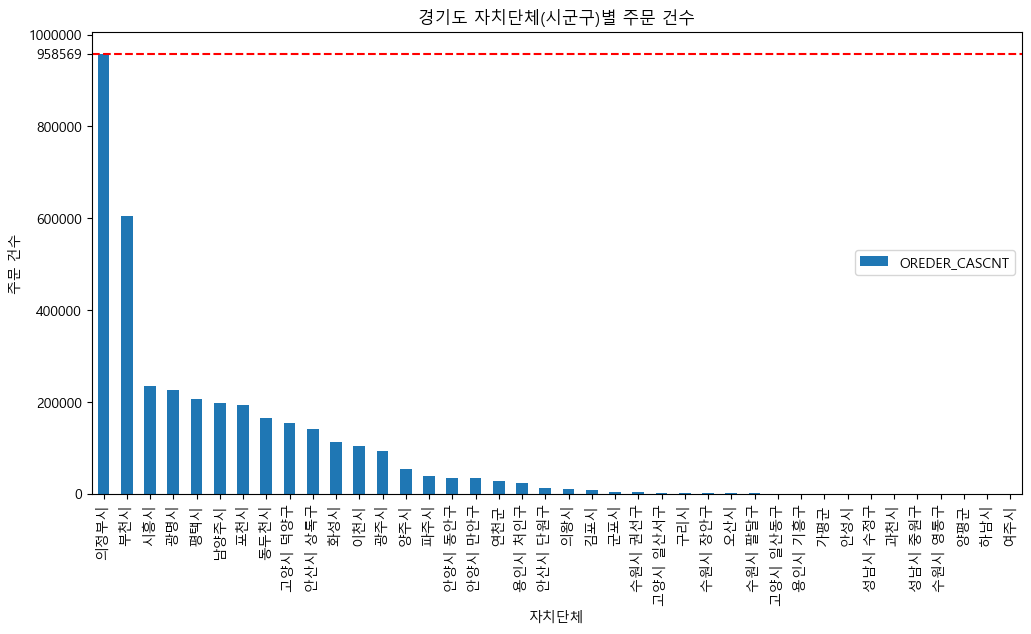

In [331]:
do, si_df = next(do_iter)
draw_si_plot(do, si_df, [i for i in range(0, 1000001, 200000)])

경기도는 의정부가 압도적 1등이다...? 보니까 몇몇 시들은 시 단위가 아닌 구 단위로 되어있긴 한데 그걸 시 단위로 집계하더라도 의정부를 이길 수가 없지 싶다.

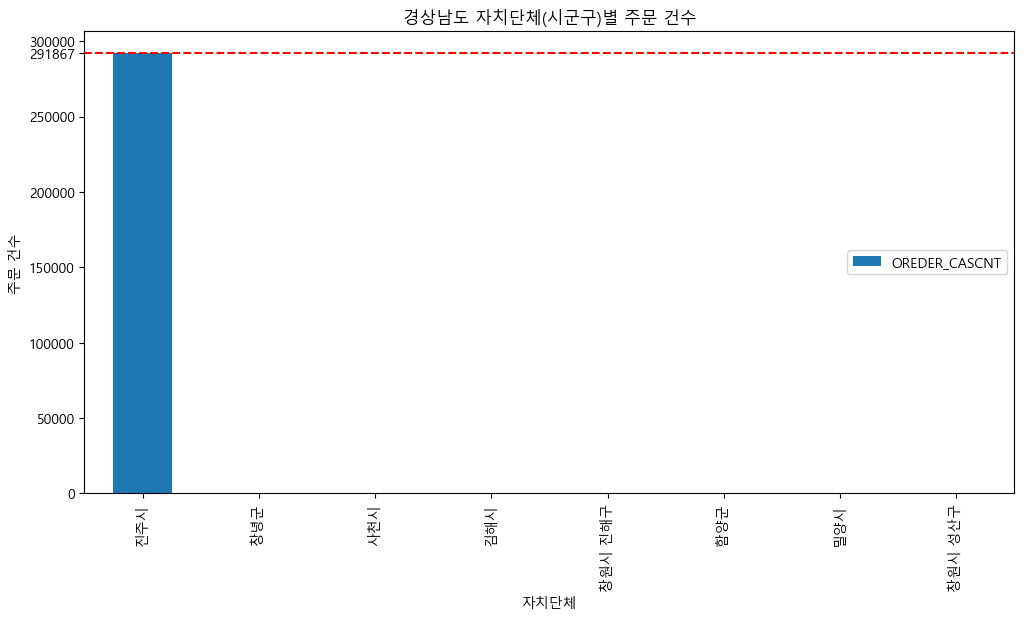

In [332]:
do, si_df = next(do_iter)
draw_si_plot(do, si_df, [i for i in range(0, 300001, 50000)])

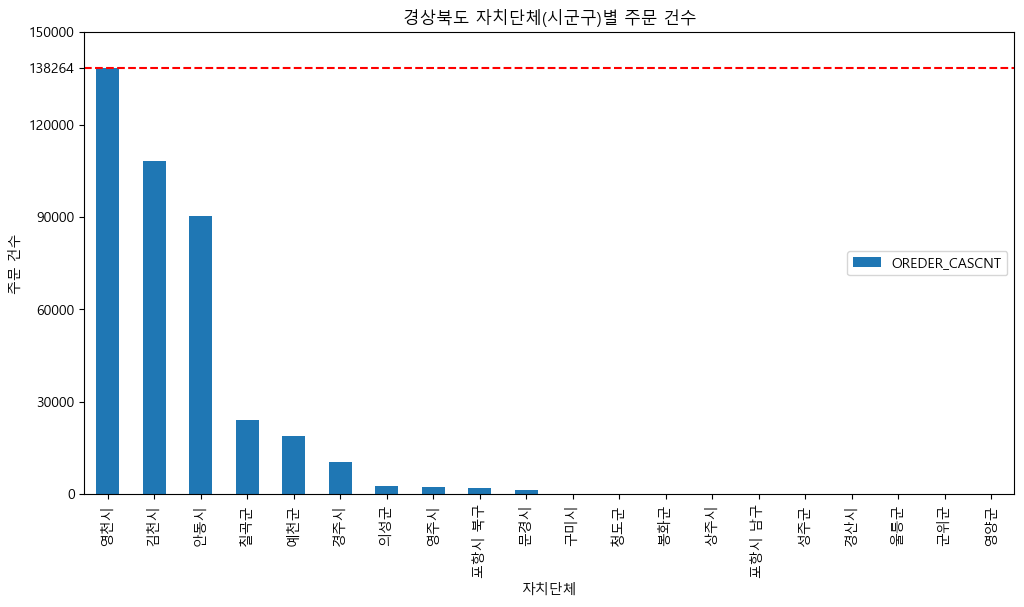

In [333]:
do, si_df = next(do_iter)
draw_si_plot(do, si_df, [i for i in range(0, 150001, 30000)])

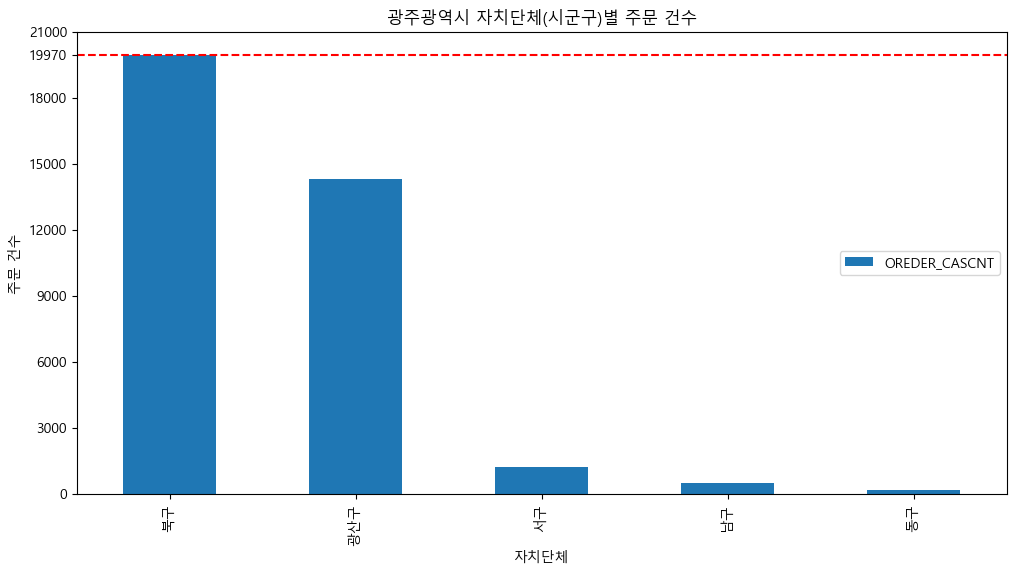

In [334]:
do, si_df = next(do_iter)
draw_si_plot(do, si_df, [i for i in range(0, 21001, 3000)])

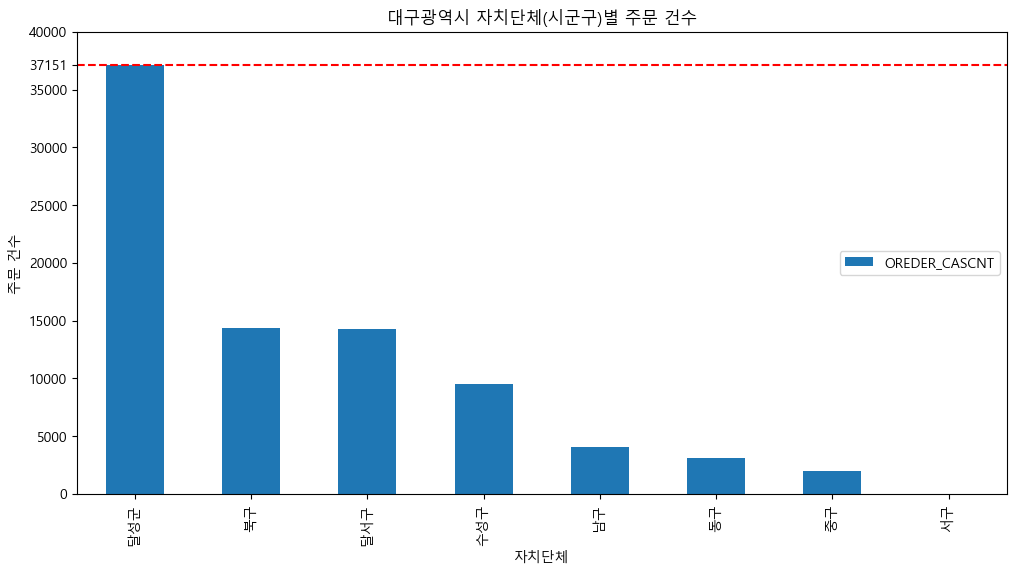

In [335]:
do, si_df = next(do_iter)
draw_si_plot(do, si_df, [i for i in range(0, 40001, 5000)])

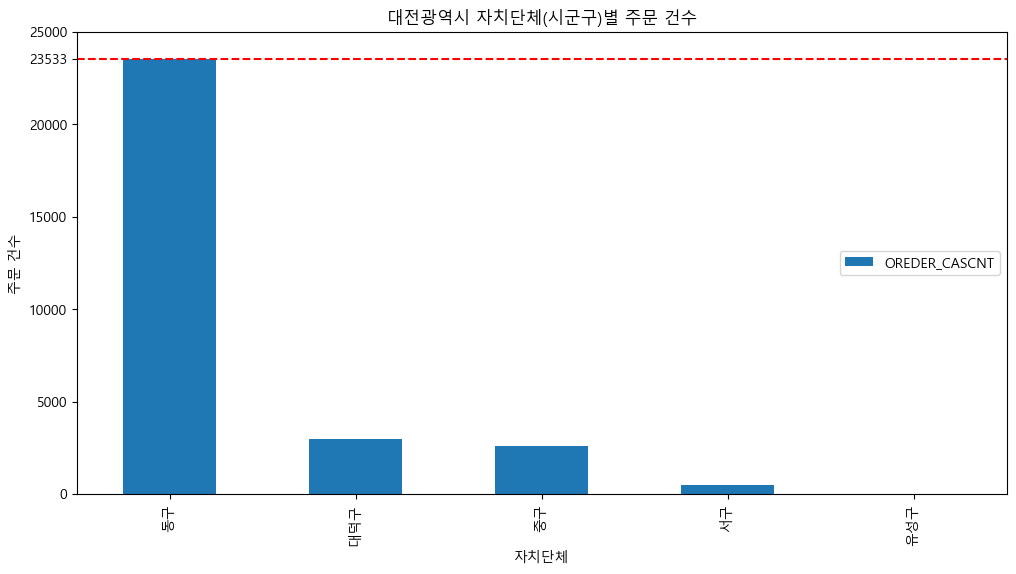

In [336]:
do, si_df = next(do_iter)
draw_si_plot(do, si_df, [i for i in range(0, 25001, 5000)])

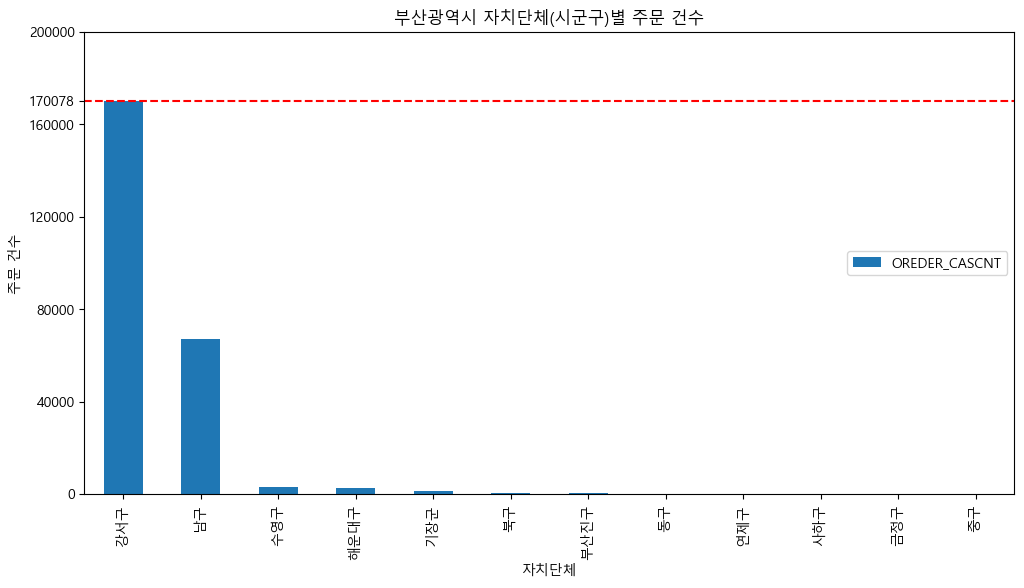

In [337]:
do, si_df = next(do_iter)
draw_si_plot(do, si_df, [i for i in range(0, 200001, 40000)])

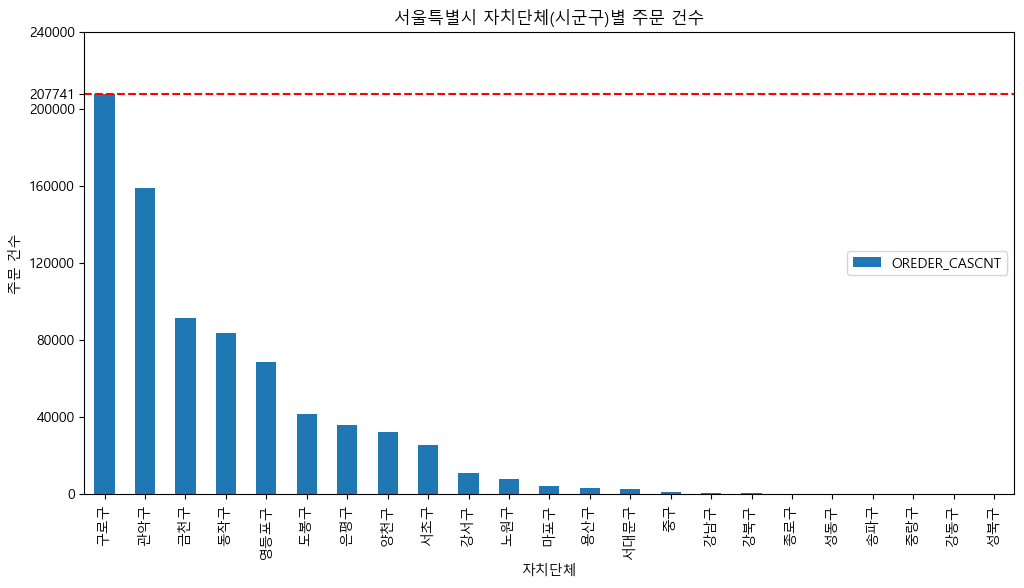

In [338]:
do, si_df = next(do_iter)
draw_si_plot(do, si_df, [i for i in range(0, 240001, 40000)])

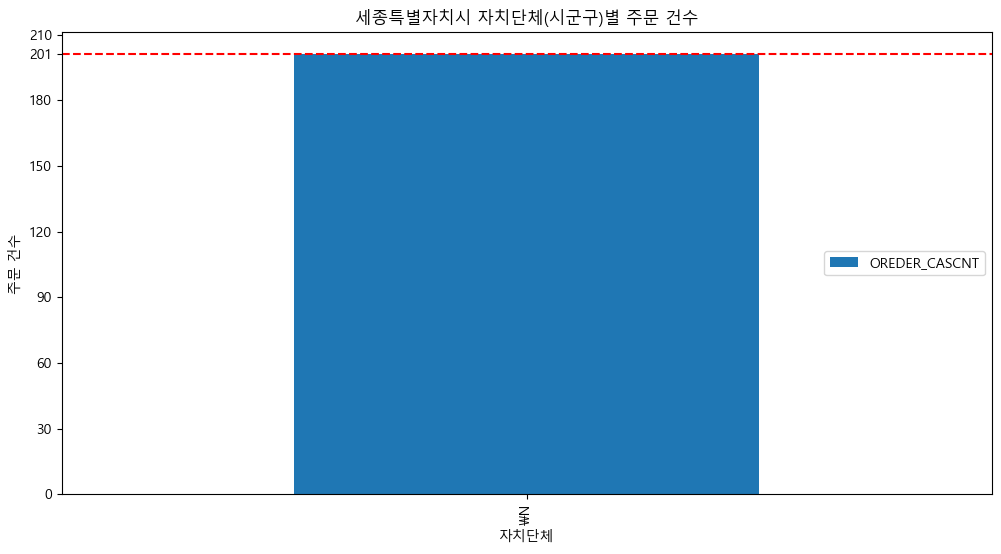

In [339]:
do, si_df = next(do_iter)
draw_si_plot(do, si_df, [i for i in range(0, 211, 30)])

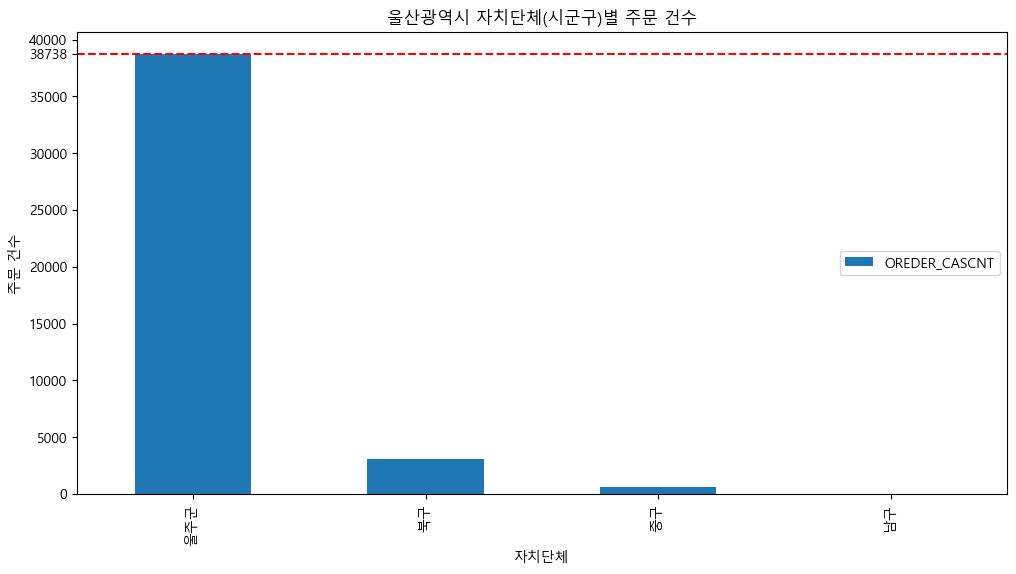

In [340]:
do, si_df = next(do_iter)
draw_si_plot(do, si_df, [i for i in range(0, 40001, 5000)])

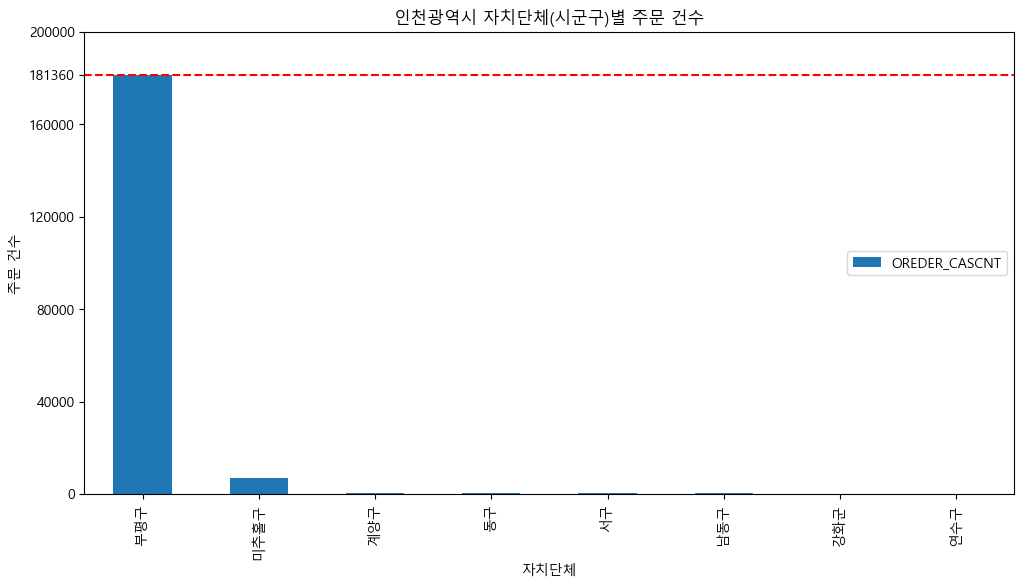

In [341]:
do, si_df = next(do_iter)
draw_si_plot(do, si_df, [i for i in range(0, 200001, 40000)])

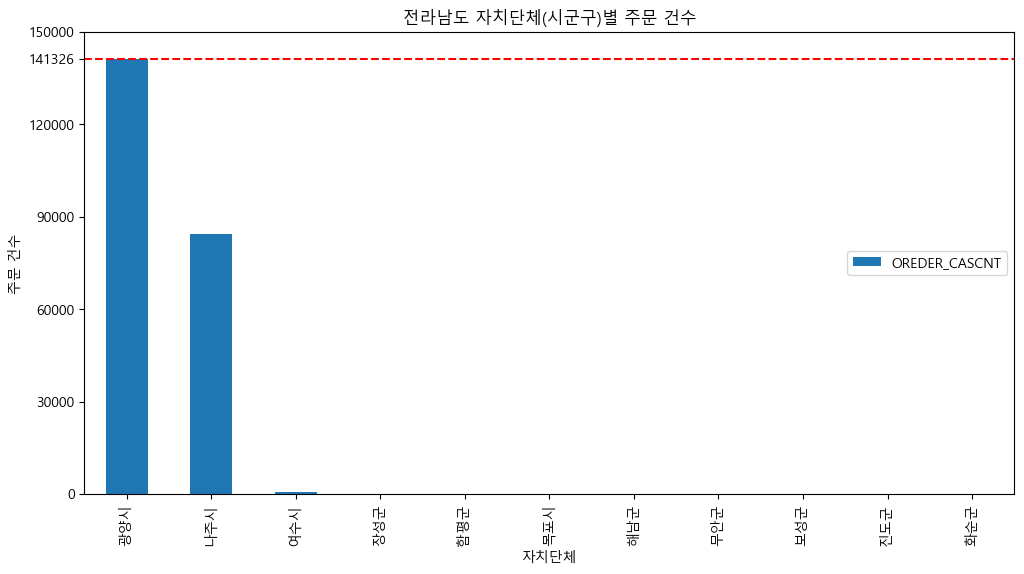

In [342]:
do, si_df = next(do_iter)
draw_si_plot(do, si_df, [i for i in range(0, 150001, 30000)])

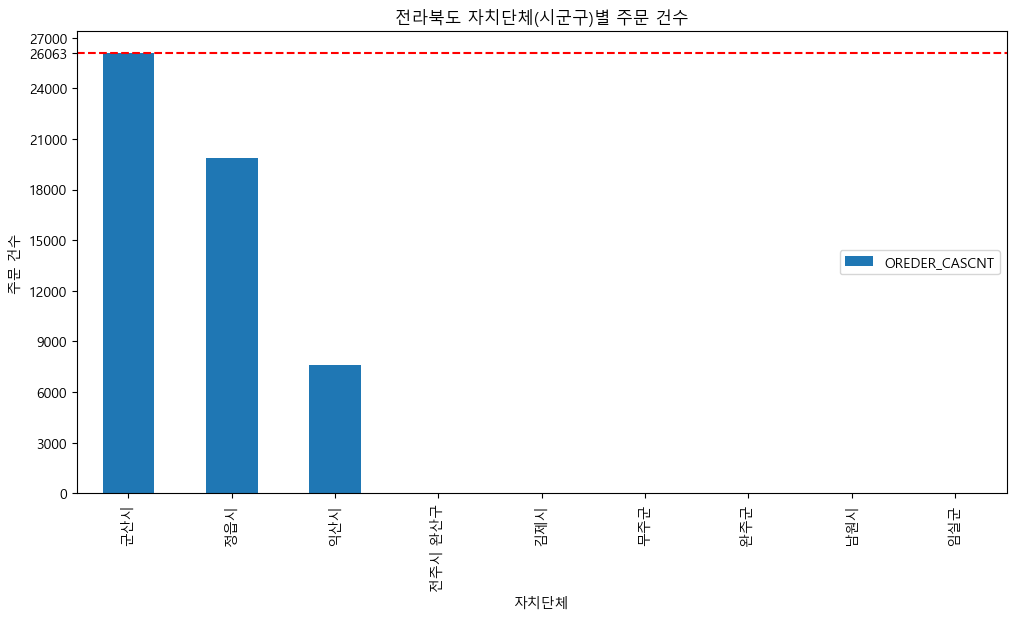

In [343]:
do, si_df = next(do_iter)
draw_si_plot(do, si_df, [i for i in range(0, 27001, 3000)])

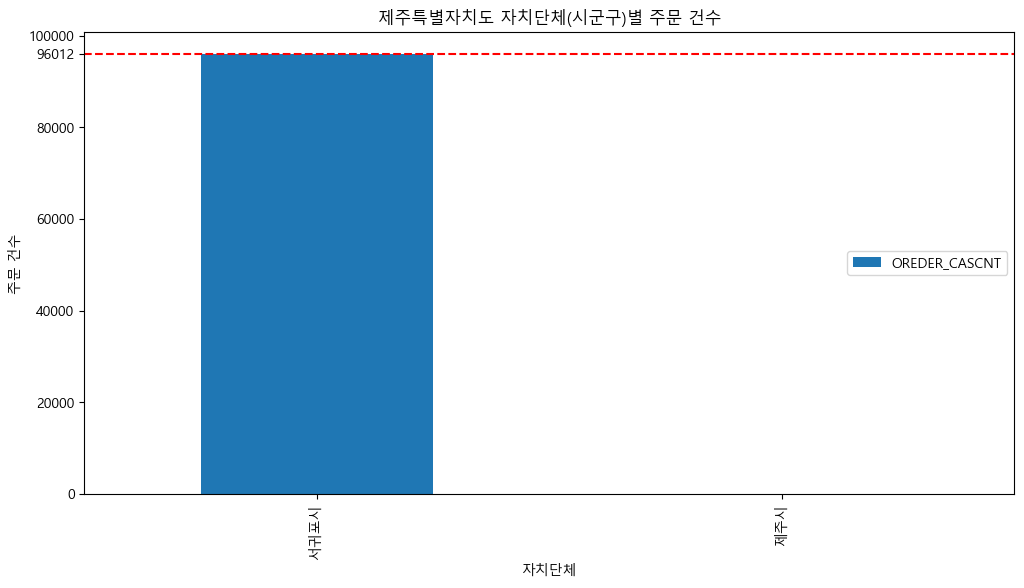

In [344]:
do, si_df = next(do_iter)
draw_si_plot(do, si_df, [i for i in range(0, 100001, 20000)])

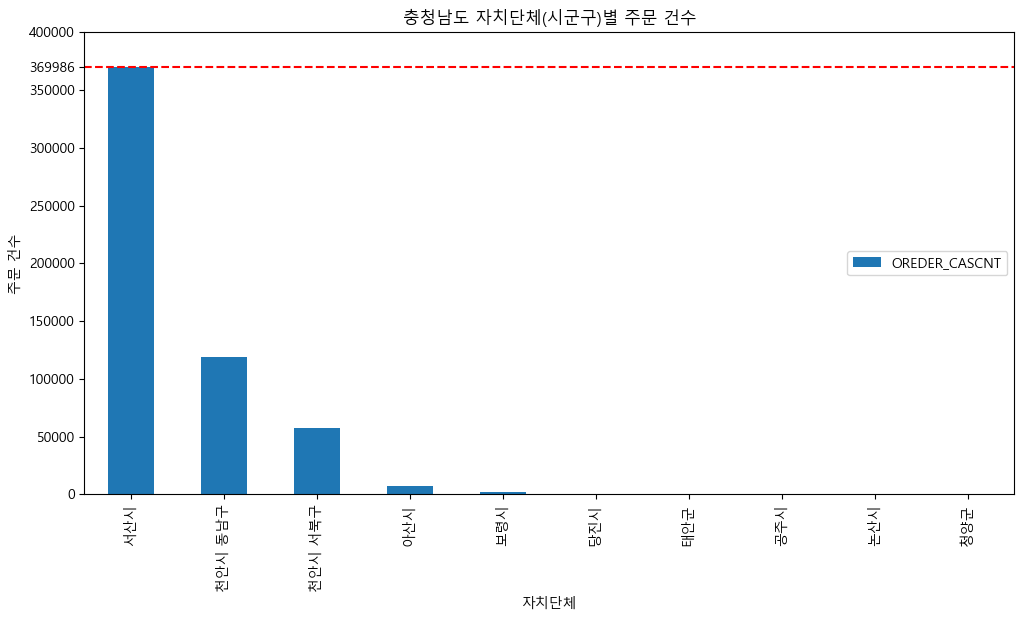

In [345]:
do, si_df = next(do_iter)
draw_si_plot(do, si_df, [i for i in range(0, 400001, 50000)])

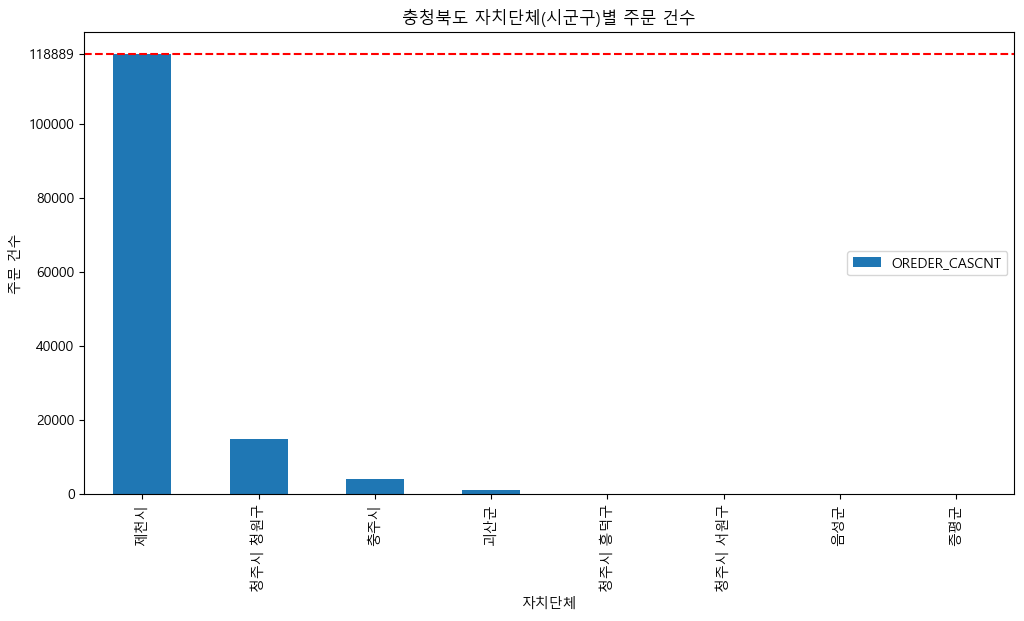

In [346]:
do, si_df = next(do_iter)
draw_si_plot(do, si_df, [i for i in range(0, 100001, 20000)])

데이터 상태가 좀 아리까리하긴 한데...

### 2-5. 컬럼별 분포 확인 (주문량)

In [260]:
delivery_df['OREDER_CASCNT'].describe()

count    1.026046e+06
mean     6.653458e+00
std      1.303801e+01
min      1.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      7.000000e+00
max      8.120000e+02
Name: OREDER_CASCNT, dtype: float64

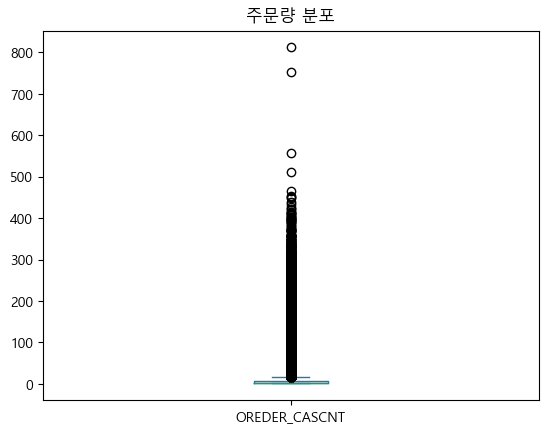

In [262]:
delivery_df['OREDER_CASCNT'].plot(kind='box')
plt.title('주문량 분포')
plt.show()

최댓값은 뭘까

In [265]:
delivery_df[delivery_df['OREDER_CASCNT'] == delivery_df['OREDER_CASCNT'].max()]

,DE,HRLY_TIME,DLVR_STORE_INDUTY_NM,DLVR_DSTN_BRTC_NM,DLVR_DSTN_SIGNGU_NM,OREDER_CASCNT,Month
717921,2021-05-14,19,돈까스/일식,경기도,부천시,812,05


경기도 부천시에서 5월 19일 저녁 시간대에 1시간 동안 돈까스/일식 주문 812건이 들어왔다고 한다.

## 3. 데이터 분석

### 3-1. 문제 정의

이만쥬(26)씨는 배달 앱 '배다른민족'의 서비스 운영 및 기획 관련 데이터 분석 업무를 수행하고 있다. 만쥬씨의 팀이 이전에 진행했던 A/B Test 및 데이터 분석을 통해 알고 있는 정보는 다음과 같다.
- 하루 중 임의 시간대에 판촉을 진행하는 것보다는 **주문량이 많은 시간대에 집중**하여 판촉을 진행하는 것이 매출 상승에 도움을 준다.
- 전체 메뉴에 대한 할인 쿠폰보다는 **특정 카테고리**에 대한 할인 쿠폰을 발급해 주는 것이 매출 상승에 도움을 준다.

만쥬씨는 '배다른민족'의 매출 상승을 위해, 어떤 시간대에 어떤 카테고리에 대한 마케팅 활동을 진행해야 할지 알아보고자 한다. 본 분석에서는 만쥬씨의 입장에서 목표를 완수하기 위한 분석을 수행한다.

In [5]:
delivery_df

,DE,HRLY_TIME,DLVR_STORE_INDUTY_NM,DLVR_DSTN_BRTC_NM,DLVR_DSTN_SIGNGU_NM,OREDER_CASCNT,Month
0,2021-01-01,0,돈까스/일식,경기도,동두천시,3,01
1,2021-01-01,0,돈까스/일식,경기도,부천시,49,01
2,2021-01-01,0,돈까스/일식,경기도,안산시 상록구,5,01
3,2021-01-01,0,돈까스/일식,경기도,의정부시,6,01
4,2021-01-01,0,돈까스/일식,경상남도,진주시,3,01
...,...,...,...,...,...,...,...
1026041,2021-07-31,23,한식,제주특별자치도,서귀포시,1,07
1026042,2021-07-31,23,한식,충청남도,천안시 서북구,2,07
1026043,2021-07-31,23,회,경기도,이천시,2,07
1026044,2021-07-31,23,회,전라남도,광양시,2,07


### 3-2. 문제 1 (시간대 선정)

주문량이 많은 시간대에 집중하여 판촉을 진행하는 것이 좋으므로, 어떤 시간대에 마케팅 활동을 진행할지 확인해 보도록 한다.

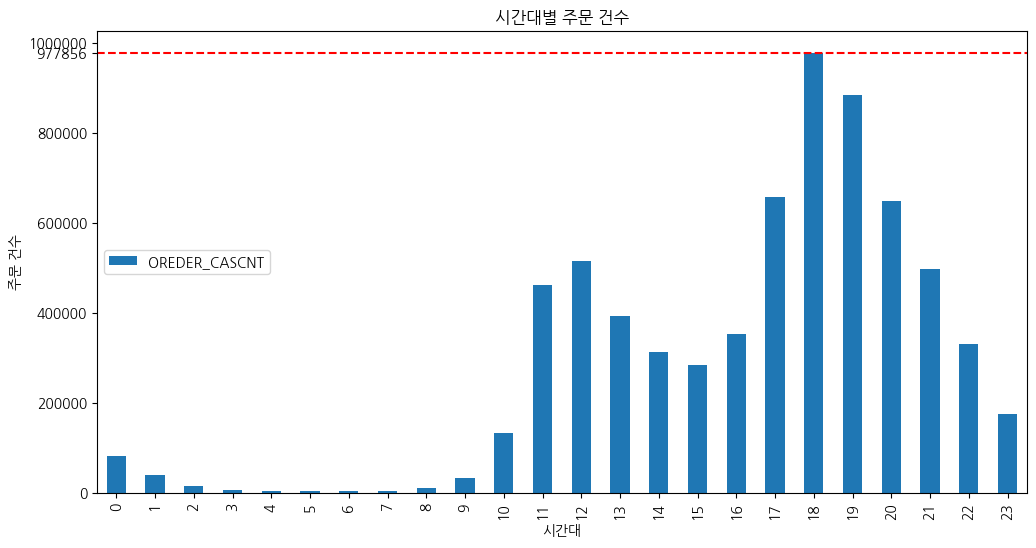

In [9]:
count_by_time.plot(kind='bar', figsize=(12, 6))
plt.title('시간대별 주문량')
plt.xlabel('시간대')
plt.ylabel('주문량')
plt.yticks([i for i in range(0, 1000001, 200000)] + [count_by_time.max().item()])
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
plt.axhline(count_by_time.max().item(), color='red', linestyle='--')
plt.show()

눈으로 짐작해봤을 때 저녁 시간대에 주문량이 많기는 하나 더욱 정밀히 알아보기 위해 KMeansClustering을 수행한다.

In [7]:
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(count_by_time)
delivery_df['TIME_RANGE'] = delivery_df['HRLY_TIME'].apply(lambda x:clusters[x])
delivery_df

C:\Users\louis\anaconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,DE,HRLY_TIME,DLVR_STORE_INDUTY_NM,DLVR_DSTN_BRTC_NM,DLVR_DSTN_SIGNGU_NM,OREDER_CASCNT,Month,TIME_RANGE
0,2021-01-01,0,돈까스/일식,경기도,동두천시,3,01,0
1,2021-01-01,0,돈까스/일식,경기도,부천시,49,01,0
2,2021-01-01,0,돈까스/일식,경기도,안산시 상록구,5,01,0
3,2021-01-01,0,돈까스/일식,경기도,의정부시,6,01,0
4,2021-01-01,0,돈까스/일식,경상남도,진주시,3,01,0
...,...,...,...,...,...,...,...,...
1026041,2021-07-31,23,한식,제주특별자치도,서귀포시,1,07,0
1026042,2021-07-31,23,한식,충청남도,천안시 서북구,2,07,0
1026043,2021-07-31,23,회,경기도,이천시,2,07,0
1026044,2021-07-31,23,회,전라남도,광양시,2,07,0


In [8]:
delivery_df['TIME_RANGE'].value_counts()

2    378790
3    321276
1    182626
0    143354
Name: TIME_RANGE, dtype: int64

24개의 시간대를 총 4개의 클러스터로 분류했다.

In [9]:
for idx, df in delivery_df.groupby('HRLY_TIME'):
    print(f'''{idx}시는 {df['TIME_RANGE'].mode()[0]} 클러스터에 해당''')

0시는 0 클러스터에 해당
1시는 0 클러스터에 해당
2시는 0 클러스터에 해당
3시는 0 클러스터에 해당
4시는 0 클러스터에 해당
5시는 0 클러스터에 해당
6시는 0 클러스터에 해당
7시는 0 클러스터에 해당
8시는 0 클러스터에 해당
9시는 0 클러스터에 해당
10시는 0 클러스터에 해당
11시는 2 클러스터에 해당
12시는 2 클러스터에 해당
13시는 3 클러스터에 해당
14시는 3 클러스터에 해당
15시는 3 클러스터에 해당
16시는 3 클러스터에 해당
17시는 2 클러스터에 해당
18시는 1 클러스터에 해당
19시는 1 클러스터에 해당
20시는 2 클러스터에 해당
21시는 2 클러스터에 해당
22시는 3 클러스터에 해당
23시는 0 클러스터에 해당


In [10]:
delivery_df.groupby('HRLY_TIME', as_index=False).agg({'TIME_RANGE': 'max'})

,HRLY_TIME,TIME_RANGE
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


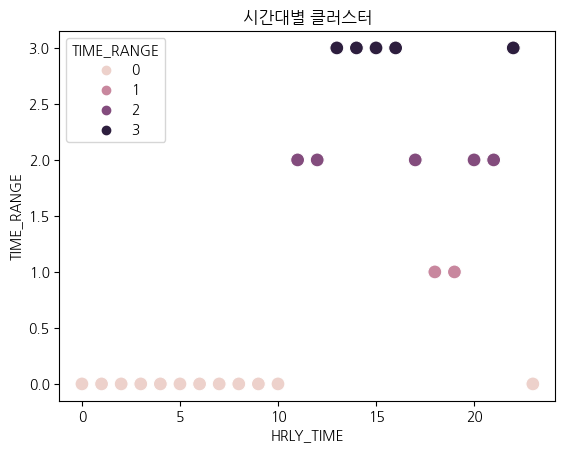

In [11]:
sns.scatterplot(
    delivery_df.groupby('HRLY_TIME', as_index=False).agg({'TIME_RANGE': 'max'}),
    x='HRLY_TIME',
    y='TIME_RANGE',
    hue='TIME_RANGE',
    s=100
)
plt.title('시간대별 클러스터')
plt.show()

분류 결과는 다음과 같다.
- 0번 클러스터: 23시 ~ 익일 10시
- 1번 클러스터: 18시 ~ 19시(저녁)
- 2번 클러스터: 11시 ~ 12시(점심), 17시, 20 ~ 21시(저녁 전후)
- 3번 클러스터: 13시 ~ 16시(오후), 22시(야간)

이제 클러스터별 특성치를 확인해본다.

In [14]:
delivery_df.groupby('TIME_RANGE').agg({'OREDER_CASCNT': 'mean'})

,OREDER_CASCNT
TIME_RANGE,
0,3.569590
1,10.198712
2,7.338430
3,5.206629


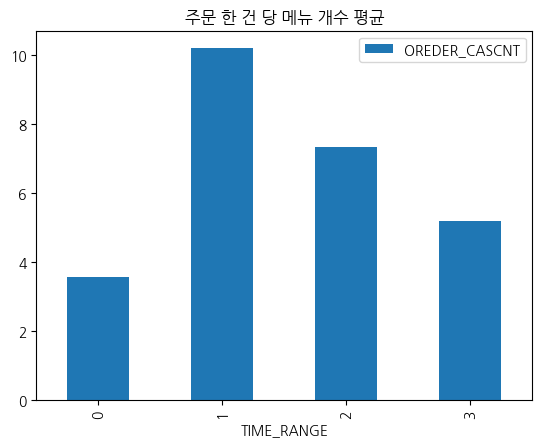

In [24]:
delivery_df.groupby('TIME_RANGE').agg({'OREDER_CASCNT': 'mean'}).plot(kind='bar')
plt.title('주문 한 건 당 메뉴 개수 평균')
plt.show()

주문 한 건당 주문량을 확인해 보니, **1번 클러스터에서 압도적**으로 많다.

In [21]:
time_by_range = delivery_df.groupby('TIME_RANGE').agg({'OREDER_CASCNT': 'sum', 'HRLY_TIME': 'nunique'})
time_by_range['1시간 주문량 평균'] = time_by_range['OREDER_CASCNT'] / time_by_range['HRLY_TIME']
time_by_range

,OREDER_CASCNT,HRLY_TIME,1시간 주문량 평균
TIME_RANGE,,,
0,511715,12,42642.916667
1,1862550,2,931275.000000
2,2779724,5,555944.800000
3,1672765,5,334553.000000


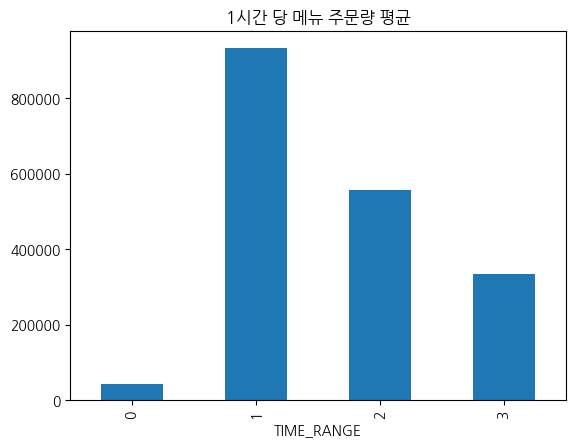

In [26]:
time_by_range['1시간 주문량 평균'].plot(kind='bar')
plt.title('1시간 당 메뉴 주문량 평균')
plt.show()

전체 주문량 합으로 봤을 때 2번 클러스터가 가장 많은 것처럼 보이지만, 사실 1번 클러스터는 2시간, 2번 클러스터는 5시간으로 이루어져 있다는 함정이 있다. 그래서 클러스터별로 1시간 단위 주문량 평균을 보면 역시 **1번 클러스터가 가장 많은 점** 확인할 수 있다.

그렇다면 **18시 ~ 19시**에 가장 판촉을 진행하는 것이 가장 효과적이겠다.

### 3-3. 문제 2 (메뉴 선정)

이제 18시 ~ 19시 시간대에 어떤 메뉴가 높은 주문량을 보이는지 확인해 보자.

In [27]:
dinner_df = delivery_df[delivery_df['TIME_RANGE'] == 1]
dinner_df

,DE,HRLY_TIME,DLVR_STORE_INDUTY_NM,DLVR_DSTN_BRTC_NM,DLVR_DSTN_SIGNGU_NM,OREDER_CASCNT,Month,TIME_RANGE
3908,2021-01-01,18,도시락,경기도,부천시,5,01,1
3909,2021-01-01,18,도시락,경기도,의정부시,3,01,1
3910,2021-01-01,18,도시락,경기도,평택시,3,01,1
3911,2021-01-01,18,도시락,경기도,포천시,6,01,1
3912,2021-01-01,18,도시락,경기도,화성시,2,01,1
...,...,...,...,...,...,...,...,...
1024968,2021-07-31,19,회,전라남도,광양시,2,07,1
1024969,2021-07-31,19,회,전라남도,나주시,3,07,1
1024970,2021-07-31,19,회,충청남도,서산시,8,07,1
1024971,2021-07-31,19,회,충청남도,천안시 동남구,3,07,1


In [28]:
dinner_df['HRLY_TIME'].value_counts()

18    92645
19    89981
Name: HRLY_TIME, dtype: int64

In [35]:
dinner_menu_df = dinner_df.groupby('DLVR_STORE_INDUTY_NM', as_index=False).agg(
    {'OREDER_CASCNT': 'sum'}
).sort_values('OREDER_CASCNT', ascending=False).reset_index(drop=True)

dinner_menu_df

,DLVR_STORE_INDUTY_NM,OREDER_CASCNT
0,돈까스/일식,365076
1,치킨,349903
2,한식,228445
3,분식,150087
4,카페/디저트,137887
5,족발/보쌈,118865
6,찜탕,87996
7,패스트푸드,80997
8,야식,80507
9,중식,77152


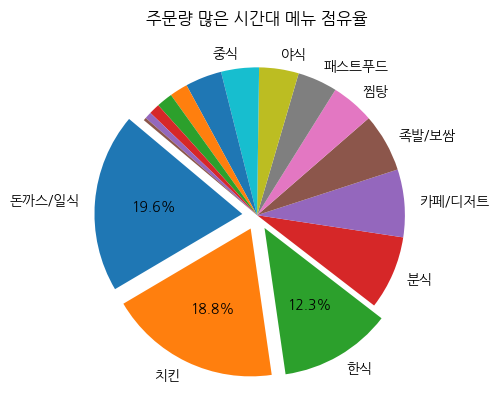

In [67]:
def custom_autopct(pct):
    val = int(round(pct * sum(dinner_menu_df['OREDER_CASCNT']) / 100.0))
    for i in range(3):
        if val == dinner_menu_df['OREDER_CASCNT'].iloc[i]:
            return f'{pct:.1f}%'
    return None

plt.pie(
    dinner_menu_df['OREDER_CASCNT'],
    explode=[0.1 if i < 3 else 0 for i in range(len(dinner_menu_df))],
    labels=[dinner_menu_df['DLVR_STORE_INDUTY_NM'].iloc[i] if i < 10 else None for i in range(len(dinner_menu_df))],
    startangle=140,
#     autopct='%1.1f%%'
    autopct=custom_autopct
)
plt.title('주문량 많은 시간대 메뉴 점유율')
plt.show()

상위 3개 메뉴는 돈까스/일식(19.6%), 치킨(18.8%), 한식(12.3%)로 나타났는데 특히 **1위와 2위의 격차가 거의 없는 것**으로 보인다. 더 자세히 알아보기 위해 돈까스/일식의 평균 주문량과, 치킨의 평균 주문량 사이에 통계적으로 유의미한 차이가 있는지 검정해본다.

다음과 같이 가설을 설정할 수 있다.
- $H_0$: 18시 ~ 19시 시간대 돈까스/일식의 평균 주문량과 치킨의 평균 주문량에는 차이가 없다.
- $H_1$: 18시 ~ 19시 시간대 돈까스/일식의 평균 주문량이 치킨의 평균 주문량보다 유의미하게 많다.

표본의 크기가 충분히 크므로 정규분포 따른다고 가정한다.

In [89]:
statistic, p_value = stats.levene(
    dinner_df[dinner_df['DLVR_STORE_INDUTY_NM'] == '돈까스/일식']['OREDER_CASCNT'],
    dinner_df[dinner_df['DLVR_STORE_INDUTY_NM'] == '치킨']['OREDER_CASCNT']
)

alpha = 0.05
if p_value < alpha:
    print("등분산 가정 만족하지 않음")
else:
    print("등분산 가정 만족")

등분산 가정 만족하지 않음


등분산이 아닌 경우의 t-test를 진행한다.

In [91]:
statistic, p_value = stats.ttest_ind(
    dinner_df[dinner_df['DLVR_STORE_INDUTY_NM'] == '돈까스/일식']['OREDER_CASCNT'],
    dinner_df[dinner_df['DLVR_STORE_INDUTY_NM'] == '치킨']['OREDER_CASCNT'],
    equal_var=False,
    alternative='greater'
)

alpha = 0.05
if p_value < alpha:
    print("18시 ~ 19시 시간대 돈까스/일식의 평균 주문량이 치킨의 평균 주문량보다 유의미하게 많다.")
else:
    print("18시 ~ 19시 시간대 돈까스/일식의 평균 주문량과 치킨의 평균 주문량에는 차이가 없다.")

18시 ~ 19시 시간대 돈까스/일식의 평균 주문량이 치킨의 평균 주문량보다 유의미하게 많다.


두 평균의 차이를 검정해 본 결과 돈까스/일식이 치킨보다 **유의미하게 많이 주문**되고 있음을 파악할 수 있다.

### 3-4. 결과 해석 및 결론 도출

이상의 분석 결과를 통해, 만쥬씨는 **저녁 시간대**에 **돈까스/일식**의 판촉을 진행하는 것이 좋겠다는 결론을 얻었다. 이 분석 결과를 통해, 매일 오후 6시에 앱 푸시를 발송하여, 돈까스/일식 카테고리에만 적용할 수 있는 할인 쿠폰을 선착순으로 발급하는 게릴라성 이벤트를 개최하기로 결정했다.

## 4. 후기

2021년 배달 데이터를 활용하여 업황을 확인해 보고, 배달 업계 구성원의 입장에서 어떤 전략을 가지고 사업을 풀어나가면 좋을지에 대해서도 고민해 보았다. 내가 실제 업계 종사자는 아니기 때문에 임의로 몇 가지 내용들을 가정하여 문제를 정의했지만, 실제 업계에서 활동하는 가상의 인물 만쥬씨는 보다 구체적인 데이터로부터 더욱 정확한 결과를 도출해 낼 수 있을 것이다. 결국 데이터 확보의 문제다.

이번 분석 과정에서 파이 차트 그리는 방법을 중점적으로 배울 수 있었다. 예를 들어 ```autopct```에 커스텀 함수를 넣어줄 수 있다는 부분을 최초로 알게 됐다. 이전까지의 분석에서 꼭 하고 싶었던 **'상위 n개 항목만 % 표시'** 같은 부분을 드디어 다룰 수 있게 되어 만족스러웠다. 이전까지는 ```df.plot(kind='pie')```로 하느라 아무래도 원래 matplotlib의 함수인 ```plt.pie()```보다는 제한적일 수밖에 없었던 것 같다.

가설 검정 과정에서 **정규성, 등분산성 가정**에 대해 고려하는 것은 필수적이라고 한다. 정규성 검정, 등분산 검정은 scipy 모듈로 두어 줄이면 끝나는 만큼 앞으로도 꼭 같이 진행해 주어야겠다. 통계 스터디를 진행하면서 해당 내용에 대한 이론적 기반을 닦을 예정인 만큼 기본기를 튼튼하게 해두는 것은 필수다.